In [3]:

# 用于查看训练集和测试集数据
# 运行本文件，需在同级目录新建data文件夹，并放入测试集与训练集数据文件

'''
Package                  Version
------------------------ ----------
certifi                  2024.8.30
charset-normalizer       3.3.2
cmake                    3.30..3
filelock                 3.16.0
h5py                     3.11.0
hdf5                     1.12.1
idna                     3.8
Jinja2                   3.1.4
lit                      18.1.8
MarkupSafe               2.1.5
mpmath                   1.3.0
networkx                 3.3
numpy                    1.26.0
nvidia-cublas-cu11       11.10.3.66
nvidia-cuda-cupti-cu11   11.7.101
nvidia-cuda-nvrtc-cu11   11.7.99
nvidia-cuda-runtime-cu11 11.7.99
nvidia-cudnn-cu11        8.5.0.96
nvidia-cufft-cu11        10.9.0.58
nvidia-curand-cu11       10.2.10.91
nvidia-cusolver-cu11     11.4.0.1
nvidia-cusparse-cu11     11.7.4.91
nvidia-nccl-cu11         2.14.3
nvidia-nvtx-cu11         11.7.91
Pillow                   10.4.0
pip                      24.2
requests                 2.32.3
setuptools               72.1.0
sympy                    1.13.2
torch                    2.0.1
torchaudio               2.0.2
torchvision              0.15.2
triton                   2.0.0
typing_extensions        4.12.2
urllib3                  2.2.2
wheel                    0.43.0
'''

import os

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

import torch.nn.parallel
from torch.autograd import Variable
import numpy as np
import h5py
from tqdm import tqdm

# import provider
num_class = 10
total_epoch = 1 #30
# script_dir = os.path.dirname(__file__)  # 获取脚本所在的目录
script_dir = "./"

class STN3d(nn.Module):
    def __init__(self, channel):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32))).view(1, 9).repeat(
            batchsize, 1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1, self.k * self.k).repeat(
            batchsize, 1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x


class PointNetEncoder(nn.Module):
    def __init__(self, global_feat=True, feature_transform=False, channel=3):
        super(PointNetEncoder, self).__init__()
        self.stn = STN3d(channel)
        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        B, D, N = x.size()
        trans = self.stn(x)
        x = x.transpose(2, 1)
        if D > 3:
            feature = x[:, :, 3:]
            x = x[:, :, :3]
        x = torch.bmm(x, trans)
        if D > 3:
            x = torch.cat([x, feature], dim=2)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2, 1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2, 1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, N)
            return torch.cat([x, pointfeat], 1), trans, trans_feat


def feature_transform_reguliarzer(trans):
    d = trans.size()[1]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2, 1)) - I, dim=(1, 2)))
    return loss


# 模型定义
class get_model(nn.Module):
    def __init__(self, k=10, normal_channel=False):
        super(get_model, self).__init__()
        if normal_channel:
            channel = 6
        else:
            channel = 3
        self.feat = PointNetEncoder(global_feat=True, feature_transform=True, channel=channel)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.4)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x, trans_feat

class get_loss(torch.nn.Module):
    def __init__(self, mat_diff_loss_scale=0.001):
        super(get_loss, self).__init__()
        self.mat_diff_loss_scale = mat_diff_loss_scale

    def forward(self, pred, target, trans_feat):
        loss = F.nll_loss(pred, target)
        mat_diff_loss = feature_transform_reguliarzer(trans_feat)

        total_loss = loss + mat_diff_loss * self.mat_diff_loss_scale
        return total_loss


class PointCloudDataset(Dataset):
    def __init__(self,root, split):
        self.list_of_points = []
        self.list_of_labels = []
        self.root = root
        self.split = split

        # with h5py.File(f"{split}_point_clouds.h5","r") as hf:
        with h5py.File(f"{self.root}/{self.split}_point_clouds.h5","r") as hf:
            for k in hf.keys():
                self.list_of_points.append(hf[k]["points"][:].astype(np.float32))
                self.list_of_labels.append(hf[k].attrs["label"])
        # self.fix_length_statistics_with_median() #注意，提供给大家的模板代码，这句是没有被注释的

    def __len__(self):
        return len(self.list_of_points)

    def __getitem__(self, idx):
        points = self.list_of_points[idx]
        label = self.list_of_labels[idx]
        return points, label

    def fix_length_statistics_with_median(self):
        lengths = [points.shape[0] for points in self.list_of_points]
        fix_length = int( np.median(lengths) )
        
        new_list_of_points = []
        for points in self.list_of_points:
            if(points.shape[0] >= fix_length):
                new_list_of_points.append(points[:fix_length, :])
            else:
                new_list_of_points.append(np.concatenate((points, np.zeros((fix_length - points.shape[0], 3), dtype=np.float32)), axis=0))
        self.list_of_points = new_list_of_points



def inplace_relu(m):
    classname = m.__class__.__name__
    if classname.find('ReLU') != -1:
        m.inplace=True


# def test(model, loader, num_class=10):
#     mean_correct = []
#     classifier = model.eval()

#     # for j, (points, target) in tqdm(enumerate(loader), total=len(loader)): #显示进度条
#     for j, (points, target) in enumerate(loader):

#         points, target = points.cuda(), target.cuda()

#         points = points.transpose(2, 1)
#         pred, _ = classifier(points)
#         pred_choice = pred.data.max(1)[1]

#         correct = pred_choice.eq(target.long().data).cpu().sum()
#         mean_correct.append(correct.item())

#     instance_acc = np.sum(mean_correct) / len(loader.dataset)

#     return instance_acc

# def pad_collate_fn(batch):
#     # 找到批次中最小的数组大小
#     min_size = min([item[0].shape[0] for item in batch])
    
#     # 截断数组
#     padded_batch = []
#     for points, target in batch:
#         # 截断数组
#         points = points[:min_size, :]
#         padded_batch.append((points, target))
    
#     # 使用默认的 collate_fn 处理填充后的批次
#     return torch.utils.data.dataloader.default_collate(padded_batch)

# provider
def shift_point_cloud(batch_data, shift_range=0.1):
    """ Randomly shift point cloud. Shift is per point cloud.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, shifted batch of point clouds
    """
    B, N, C = batch_data.shape
    shifts = np.random.uniform(-shift_range, shift_range, (B,3))
    for batch_index in range(B):
        batch_data[batch_index,:,:] += shifts[batch_index,:]
    return batch_data


def random_scale_point_cloud(batch_data, scale_low=0.8, scale_high=1.25):
    """ Randomly scale the point cloud. Scale is per point cloud.
        Input:
            BxNx3 array, original batch of point clouds
        Return:
            BxNx3 array, scaled batch of point clouds
    """
    B, N, C = batch_data.shape
    scales = np.random.uniform(scale_low, scale_high, B)
    for batch_index in range(B):
        batch_data[batch_index,:,:] *= scales[batch_index]
    return batch_data

def random_point_dropout(batch_pc, max_dropout_ratio=0.875):
    ''' batch_pc: BxNx3 '''
    for b in range(batch_pc.shape[0]):
        dropout_ratio =  np.random.random()*max_dropout_ratio # 0~0.875
        drop_idx = np.where(np.random.random((batch_pc.shape[1]))<=dropout_ratio)[0]
        if len(drop_idx)>0:
            batch_pc[b,drop_idx,:] = batch_pc[b,0,:] # set to the first point
    return batch_pc

# 保存模型参数和缓冲区为 .txt 文件
def save_model_params_and_buffers_to_txt(model, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # 保存所有参数
    for name, param in model.named_parameters():
        np.savetxt(os.path.join(directory, f'{name}.txt'), param.detach().cpu().numpy().flatten())
    
    # 保存所有缓冲区
    for name, buffer in model.named_buffers():
        np.savetxt(os.path.join(directory, f'{name}.txt'), buffer.detach().cpu().numpy().flatten())


In [17]:
data_path = './data'

train_dataset = PointCloudDataset(root=data_path, split='train')
test_dataset = PointCloudDataset(root=data_path, split='test')


In [8]:

print("points:\n", train_dataset.list_of_points[0].shape,"\n", train_dataset.list_of_points[0])
print("label:\n", train_dataset.list_of_labels[0])

points:
 (25700, 3) 
 [[ 0.15       -0.1094358   0.47305447]
 [ 0.15       -0.0969358   0.47305447]
 [ 0.15       -0.0844358   0.47305447]
 ...
 [ 0.15       -0.1094358  -0.5019455 ]
 [ 0.15       -0.1094358  -0.51444554]
 [ 0.15       -0.1094358  -0.52694553]]
label:
 5


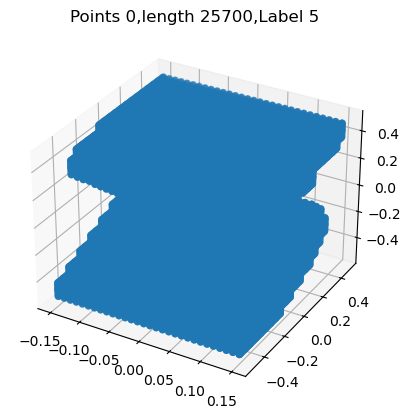

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# points 是一个形状为 (N, 3) 的 NumPy 数组
# points = np.array([[x1, y1, z1],
#                    [x2, y2, z2],
#                    ...,
#                    [xN, yN, zN]])

point_id = 0
points = train_dataset.list_of_points[point_id]

# 创建一个新的图形
fig = plt.figure()
# 创建一个 3D 轴
ax = fig.add_subplot(111, projection='3d')

# 在图上绘制点
xs = points[:, 0]
ys = points[:, 1]
zs = points[:, 2]
ax.scatter(xs, ys, zs)

ax.set_title(f"Points {point_id},length {len(train_dataset.list_of_points[point_id])},Label {train_dataset.list_of_labels[point_id]}")

# 显示图形
plt.show()

In [4]:
print("训练集点云数量： ",len(train_dataset.list_of_points))
print("训练集第一个样本（点云）的尺寸： ", train_dataset.list_of_points[0].shape)
print("训练集第二个样本（点云）的尺寸： ", train_dataset.list_of_points[1].shape)
print("训练集第三个样本（点云）的尺寸： ", train_dataset.list_of_points[2].shape)

print("测试集点云数量： ",len(test_dataset.list_of_points))
print("测试集第一个样本（点云）的尺寸： ", test_dataset.list_of_points[0].shape)
print("测试集第二个样本（点云）的尺寸： ", test_dataset.list_of_points[1].shape)
print("测试集第三个样本（点云）的尺寸： ", test_dataset.list_of_points[2].shape)


训练集点云数量：  5000
训练集第一个样本（点云）的尺寸：  (25700, 3)
训练集第二个样本（点云）的尺寸：  (26200, 3)
训练集第三个样本（点云）的尺寸：  (20950, 3)
测试集点云数量：  1000
测试集第一个样本（点云）的尺寸：  (19000, 3)
测试集第二个样本（点云）的尺寸：  (25050, 3)
测试集第三个样本（点云）的尺寸：  (27050, 3)


In [11]:
# 对所有样本作截取/填充操作
train_dataset.fix_length_statistics_with_median()

print("训练集第一个样本（点云）的尺寸： ", train_dataset.list_of_points[0].shape)
print("训练集第二个样本（点云）的尺寸： ", train_dataset.list_of_points[1].shape)
print("训练集第三个样本（点云）的尺寸： ", train_dataset.list_of_points[2].shape)


训练集第一个样本（点云）的尺寸：  (23050, 3)
训练集第二个样本（点云）的尺寸：  (23050, 3)
训练集第三个样本（点云）的尺寸：  (23050, 3)


In [14]:
print("points:\n", train_dataset.list_of_points[2].shape,"\n", train_dataset.list_of_points[2])
print("label:\n", train_dataset.list_of_labels[2])

points:
 (23050, 3) 
 [[ 0.15       -0.14027447  0.54027444]
 [ 0.15       -0.12777446  0.54027444]
 [ 0.15       -0.11527447  0.54027444]
 ...
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
label:
 3


In [19]:
print("test points[0]:\n", test_dataset.list_of_points[0])

test points[0]:
 [[ 0.15       -0.43184212  0.40394738]
 [ 0.15       -0.4193421   0.40394738]
 [ 0.15       -0.4068421   0.40394738]
 ...
 [ 0.15       -0.03184211 -0.5710526 ]
 [ 0.15       -0.03184211 -0.58355266]
 [ 0.15       -0.03184211 -0.59605265]]
